In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

--2025-01-18 08:40:45--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz [following]
--2025-01-18 08:40:45--  https://thor.robots.ox.ac.uk/flowers/102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  25.6MB/s    in 14s     

2025-01-18 08:41:00 (24.1 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
!tar -xvzf /content/102flowers.tgz

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2025-01-18 08:41:14--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat [following]
--2025-01-18 08:41:15--  https://thor.robots.ox.ac.uk/flowers/102/imagelabels.mat
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502 [application/octet-stream]
Saving to: ‘imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2025-01-18 08:41:15 (176 MB/s) - ‘imagelabels.mat’ saved [502/502]



In [ ]:
!pip install scipy

In [ ]:
!pip install tensorflow

# VGG19

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

## Load Data

In [ ]:
import os
import shutil
import random
import scipy.io

# Paths
original_dataset_dir = "/content/jpg"  # Path to your folder of images (all images in one folder)
labels_path = "/content/imagelabels.mat"  # Path to imagelabels.mat
output_dir = "output_splits"  # Path to store the split datasets
os.makedirs(output_dir, exist_ok=True)

# Configuration
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25
repeats = 2  # Number of repeated splits

# Load labels from .mat file
labels_data = scipy.io.loadmat(labels_path)
image_labels = labels_data['labels'][0]  # Extract labels (1-based indexing)

# Total number of classes
num_classes = len(set(image_labels))

# Create repeated splits
for i in range(repeats):
    # Create directories for the current split
    split_dir = os.path.join(output_dir, f"split_{i+1}")
    os.makedirs(split_dir, exist_ok=True)
    train_dir = os.path.join(split_dir, "train")
    val_dir = os.path.join(split_dir, "val")
    test_dir = os.path.join(split_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Organize files by class
    class_files = {class_id: [] for class_id in range(1, num_classes + 1)}

    # Populate class_files dictionary
    for idx, class_id in enumerate(image_labels):
        # Image files are named as "image_00001.jpg", "image_00002.jpg", etc.
        image_name = f"image_{idx + 1:05d}.jpg"  # Ensure 1-based indexing
        image_path = os.path.join(original_dataset_dir, image_name)
        if os.path.exists(image_path):
            class_files[class_id].append(image_name)

    # Split and move files for each class
    for class_id, files in class_files.items():
        random.shuffle(files)  # Random shuffle

        # Compute split sizes
        total_files = len(files)
        train_end = int(total_files * train_ratio)
        val_end = train_end + int(total_files * val_ratio)

        # Split the dataset
        train_files = files[:train_end]
        val_files = files[train_end:val_end]
        test_files = files[val_end:]

        # Create class-specific folders in train, val, and test directories
        os.makedirs(os.path.join(train_dir, f"class_{class_id}"), exist_ok=True)
        os.makedirs(os.path.join(val_dir, f"class_{class_id}"), exist_ok=True)
        os.makedirs(os.path.join(test_dir, f"class_{class_id}"), exist_ok=True)

        # Move files to their respective directories
        for f in train_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(train_dir, f"class_{class_id}", f))
        for f in val_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(val_dir, f"class_{class_id}", f))
        for f in test_files:
            shutil.copy(os.path.join(original_dataset_dir, f), os.path.join(test_dir, f"class_{class_id}", f))

    print(f"Split {i+1} completed.")


Split 1 completed.
Split 2 completed.


Sample flower image:


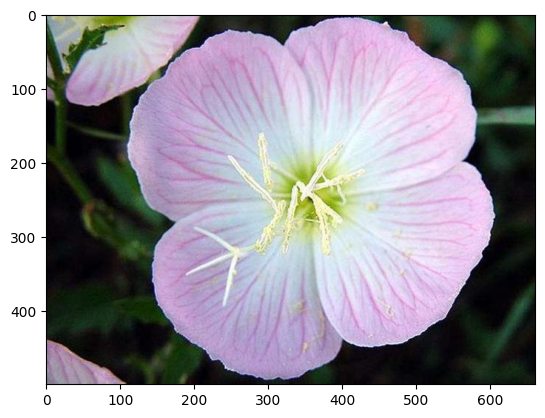

In [ ]:
split1_train_class1_dir="/content/output_splits/split_1/train/class_1"

print("Sample flower image:")
plt.imshow(load_img(f"{os.path.join(split1_train_class1_dir, os.listdir(split1_train_class1_dir)[0])}"))
plt.show()

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1.0/255. ,
                                    rotation_range=40,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest',
                                    horizontal_flip=True
                                    )

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1.0/255.
                                    )

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators("/content/output_splits/split_1/train", "/content/output_splits/split_1/val")


Found 4070 images belonging to 102 classes.
Found 2009 images belonging to 102 classes.


## Modeling

In [ ]:
def create_pre_trained_model():
  pre_trained_model = VGG19(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights='imagenet')

  pre_trained_model.trainable = False

  return pre_trained_model

In [ ]:
from tensorflow.keras.applications import VGG19


pre_trained_model = create_pre_trained_model()

# Print the model summary
pre_trained_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 20,024,384 total parameters in this model.
There are 0 trainable parameters in this model.


In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19

def create_final_model(pre_trained_model, num_classes):
    # Get the output of the last layer of the pre-trained model
    x = pre_trained_model.output  # Automatically fetches the output from block5_pool

    # Add custom layers on top of the pre-trained model
    x = layers.Flatten()(x)  # Flatten the output
    x = layers.Dense(1024, activation='relu')(x)  # Add a dense layer
    x = layers.Dropout(0.2)(x)  # Add dropout for regularization
    x = layers.Dense(num_classes, activation='softmax')(x)  # Add final softmax layer

    # Create the final model
    model = Model(inputs=pre_trained_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
# Define the number of classes for multi-class classification
num_classes = 102  # Replace with the actual number of classes

# Create the final model
final_model = create_final_model(pre_trained_model=pre_trained_model,
                                 num_classes=num_classes)

# Print the model summary
final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 28,518,566 (108.79 MB)

 Trainable params: 8,494,182 (32.40 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history = final_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=2
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


128/128 - 72s - 559ms/step - accuracy: 0.0872 - loss: 4.2748 - val_accuracy: 0.2240 - val_loss: 3.5322
Epoch 2/100
128/128 - 46s - 358ms/step - accuracy: 0.2302 - loss: 3.5137 - val_accuracy: 0.3340 - val_loss: 2.8769
Epoch 3/100
128/128 - 39s - 308ms/step - accuracy: 0.2988 - loss: 3.0453 - val_accuracy: 0.4365 - val_loss: 2.4215
Epoch 4/100
128/128 - 40s - 316ms/step - accuracy: 0.3558 - loss: 2.7041 - val_accuracy: 0.4953 - val_loss: 2.1503
Epoch 5/100
128/128 - 40s - 309ms/step - accuracy: 0.3980 - loss: 2.4695 - val_accuracy: 0.5281 - val_loss: 1.9360
Epoch 6/100
128/128 - 40s - 312ms/step - accuracy: 0.4364 - loss: 2.2624 - val_accuracy: 0.5565 - val_loss: 1.7993
Epoch 7/100
128/128 - 43s - 338ms/step - accuracy: 0.4649 - loss: 2.1440 - val_accuracy: 0.6117 - val_loss: 1.6407
Epoch 8/100
128/128 - 79s - 615ms/step - accuracy: 0.4985 - loss: 2.0175 - val_accuracy: 0.6083 - val_loss: 1.5857
Epoch 9/100
128/128 - 45s - 352ms/step - accuracy: 0.5184 - loss: 1.9365 - val_accuracy: 0.6

## Results

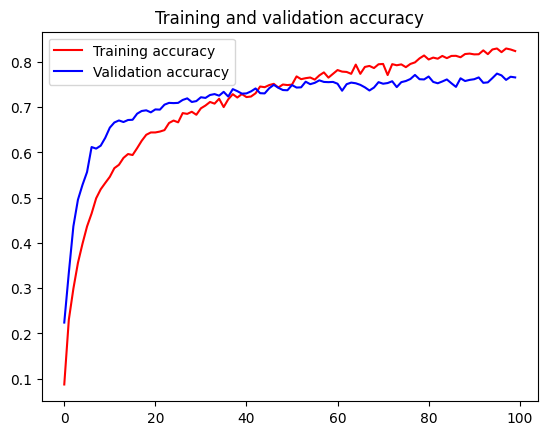

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

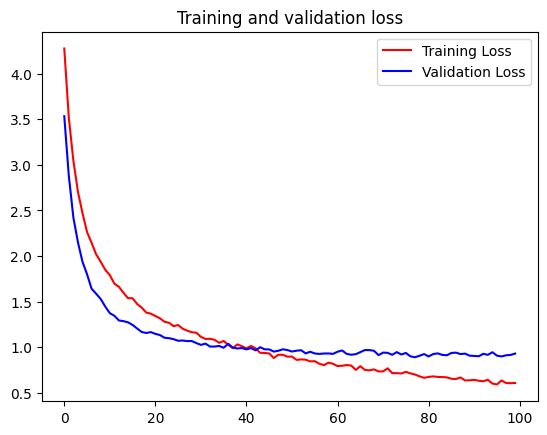

<Figure size 640x480 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test data generator
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Test generator
test_generator = test_datagen.flow_from_directory(
    directory='/content/output_splits/split_1/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Ensure this matches your training configuration
    shuffle=False
)


Found 2110 images belonging to 102 classes.


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_generator, verbose=2)

print(f"Test Accuracy: {test_accuracy:.2%}")

66/66 - 16s - 241ms/step - accuracy: 0.7555 - loss: 0.9111
Test Accuracy: 75.55%


#**Yolov5**

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
!pip install -r requirements.txt  # install


Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 17265 (delta 46), reused 10 (delta 10), pack-reused 17173 (from 5)
Receiving objects: 100% (17265/17265), 16.00 MiB | 25.17 MiB/s, done.
Resolving deltas: 100% (11791/11791), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 33.8 MB/s eta 0:00:00


## Load Data

In [ ]:
import os
import shutil
import random
import scipy.io

# Paths
original_dataset_dir = "/content/jpg"  # Path to folder of images
labels_path = "/content/imagelabels.mat"  # Path to imagelabels.mat
output_dir = "output_splits"  # Path to store the split datasets
os.makedirs(output_dir, exist_ok=True)

# Configuration
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 0.25
repeats = 2  # Number of repeated splits

# Load labels from .mat file
labels_data = scipy.io.loadmat(labels_path)
image_labels = labels_data['labels'][0]  # Extract labels (1-based indexing)

# Total number of classes
num_classes = len(set(image_labels))

# Create repeated splits
for i in range(repeats):
    # Create directories for the current split
    split_dir = os.path.join(output_dir, f"split_{i+1}")
    os.makedirs(split_dir, exist_ok=True)
    train_dir = os.path.join(split_dir, "train")
    val_dir = os.path.join(split_dir, "val")
    test_dir = os.path.join(split_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Organize files for random splitting
    all_files = []
    for idx, class_id in enumerate(image_labels):
        # Image files are named as "image_00001.jpg", "image_00002.jpg", etc.
        image_name = f"image_{idx + 1:05d}.jpg"  # Ensure 1-based indexing
        image_path = os.path.join(original_dataset_dir, image_name)
        if os.path.exists(image_path):
            all_files.append((image_name, class_id - 1))  # Add image and 0-based class_id

    random.shuffle(all_files)  # Randomize the file order

    # Compute split sizes
    total_files = len(all_files)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    # Split the dataset
    train_files = all_files[:train_end]
    val_files = all_files[train_end:val_end]
    test_files = all_files[val_end:]

    # Copy files and create labels for each split
    for split, files in zip([train_dir, val_dir, test_dir], [train_files, val_files, test_files]):
        for image_name, class_id in files:
            # Copy the image
            shutil.copy(os.path.join(original_dataset_dir, image_name), os.path.join(split, image_name))

            # Generate YOLO label (whole image as label)
            label_path = os.path.join(split, image_name.replace(".jpg", ".txt"))
            with open(label_path, 'w') as label_file:
                # YOLO format: <class_id> 0.5 0.5 1.0 1.0 (whole image as bounding box)
                label_file.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

    print(f"Split {i+1} completed.")


Split 1 completed.
Split 2 completed.


In [ ]:
# Define the paths to your dataset splits
train_path = "/content/yolov5/output_splits/split_2/train"
val_path = "/content/yolov5/output_splits/split_2/val"
test_path = "/content/yolov5/output_splits/split_2/test"

# Generate class names dynamically
num_classes = 102
class_names = [f"class_{i}" for i in range(1, num_classes + 1)]

# Create the data.yaml content
data_yaml = f"""
train: {train_path}
val: {val_path}
test: {test_path}

nc: {num_classes}  # Number of classes
names: {class_names}  # Class names
"""

# Save the data.yaml file
with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml created:")
print(data_yaml)

data.yaml created:

train: /content/yolov5/output_splits/split_2/train
val: /content/yolov5/output_splits/split_2/val
test: /content/yolov5/output_splits/split_2/test

nc: 102  # Number of classes
names: ['class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10', 'class_11', 'class_12', 'class_13', 'class_14', 'class_15', 'class_16', 'class_17', 'class_18', 'class_19', 'class_20', 'class_21', 'class_22', 'class_23', 'class_24', 'class_25', 'class_26', 'class_27', 'class_28', 'class_29', 'class_30', 'class_31', 'class_32', 'class_33', 'class_34', 'class_35', 'class_36', 'class_37', 'class_38', 'class_39', 'class_40', 'class_41', 'class_42', 'class_43', 'class_44', 'class_45', 'class_46', 'class_47', 'class_48', 'class_49', 'class_50', 'class_51', 'class_52', 'class_53', 'class_54', 'class_55', 'class_56', 'class_57', 'class_58', 'class_59', 'class_60', 'class_61', 'class_62', 'class_63', 'class_64', 'class_65', 'class_66', 'class_67', 

## Modeling

In [ ]:
# Print yolov5s.yaml content
with open('models/yolov5s.yaml', 'r') as file:
    yolov5s_config = file.read()

print(yolov5s_config)

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

In [ ]:
#Hyperparameters
!cat /content/yolov5/data/hyps/hyp.scratch-low.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Hyperparameters for low-augmentation COCO training from scratch
# python train.py --batch 64 --cfg yolov5n6.yaml --weights '' --data coco.yaml --img 640 --epochs 300 --linear
# See tutorials for hyperparameter evolution https://github.com/ultralytics/yolov5#tutorials

lr0: 0.01 # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.01 # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937 # SGD momentum/Adam beta1
weight_decay: 0.0005 # optimizer weight decay 5e-4
warmup_epochs: 3.0 # warmup epochs (fractions ok)
warmup_momentum: 0.8 # warmup initial momentum
warmup_bias_lr: 0.1 # warmup initial bias lr
box: 0.05 # box loss gain
cls: 0.5 # cls loss gain
cls_pw: 1.0 # cls BCELoss positive_weight
obj: 1.0 # obj loss gain (scale with pixels)
obj_pw: 1.0 # obj BCELoss positive_weight
iou_t: 0.20 # IoU training threshold
anchor_t: 4.0 # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
f

In [ ]:
!python train.py \
    --img 640 \
    --batch 16 \
    --epochs 50 \
    --data data.yaml \
    --cfg models/yolov5s.yaml \
    --weights yolov5s.pt \
    --hyp hyp.scratch-low.yaml \
    --freeze 10 \
    --cache

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      40/49      4.21G   0.006951   0.006044    0.04365         48        640:  63% 162/256 [00:50<00:23,  4.07it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      40/49      4.21G   0.006956   0.006052    0.04363         51        640:  64% 163/256 [00:50<00:21,  4.30it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      40/49      4.21G   0.006949   0.006055    0.04367         50        640:  64% 164/256 [00:51<00:24,  3.74it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

## Results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the results.csv file
results_path = "runs/train/exp/results.csv"

# Load the results
results = pd.read_csv(results_path)
results.head()  # Display the first few rows to understand its structure


,epoch,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,metrics/mAP_0.5,metrics/mAP_0.5:0.95,val/box_loss,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
0,0,0.036439,0.021637,0.072528,0.007956,0.964710,0.016514,0.013689,0.009527,0.003740,0.035334,0.070117,0.003320,0.003320
1,1,0.021605,0.012483,0.070542,0.009128,1.000000,0.022009,0.020906,0.008754,0.003176,0.034692,0.039985,0.006522,0.006522
2,2,0.019304,0.010678,0.071063,0.008893,0.998530,0.033021,0.023359,0.008185,0.002478,0.034281,0.009722,0.009591,0.009591
3,3,0.015558,0.009651,0.069476,0.009590,0.997520,0.055517,0.053244,0.007728,0.002595,0.032800,0.009406,0.009406,0.009406
4,4,0.013351,0.008909,0.068138,0.861830,0.058034,0.079370,0.060447,0.005851,0.002249,0.031066,0.009406,0.009406,0.009406


In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0                  epoch  50 non-null     int64  
 1         train/box_loss  50 non-null     float64
 2         train/obj_loss  50 non-null     float64
 3         train/cls_loss  50 non-null     float64
 4      metrics/precision  50 non-null     float64
 5         metrics/recall  50 non-null     float64
 6        metrics/mAP_0.5  50 non-null     float64
 7   metrics/mAP_0.5:0.95  50 non-null     float64
 8           val/box_loss  50 non-null     float64
 9           val/obj_loss  50 non-null     float64
 10          val/cls_loss  50 non-null     float64
 11                 x/lr0  50 non-null     float64
 12                 x/lr1  50 non-null     float64
 13                 x/lr2  50 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 5.6 KB


In [ ]:
print("Columns in the CSV:", results.columns.tolist())


Columns in the CSV: ['               epoch', '      train/box_loss', '      train/obj_loss', '      train/cls_loss', '   metrics/precision', '      metrics/recall', '     metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', '        val/box_loss', '        val/obj_loss', '        val/cls_loss', '               x/lr0', '               x/lr1', '               x/lr2']


In [ ]:
# Strip spaces from column names
results.columns = results.columns.str.strip()

# Verify cleaned column names
print("Cleaned Columns:", results.columns.tolist())


Cleaned Columns: ['epoch', 'train/box_loss', 'train/obj_loss', 'train/cls_loss', 'metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss', 'val/obj_loss', 'val/cls_loss', 'x/lr0', 'x/lr1', 'x/lr2']


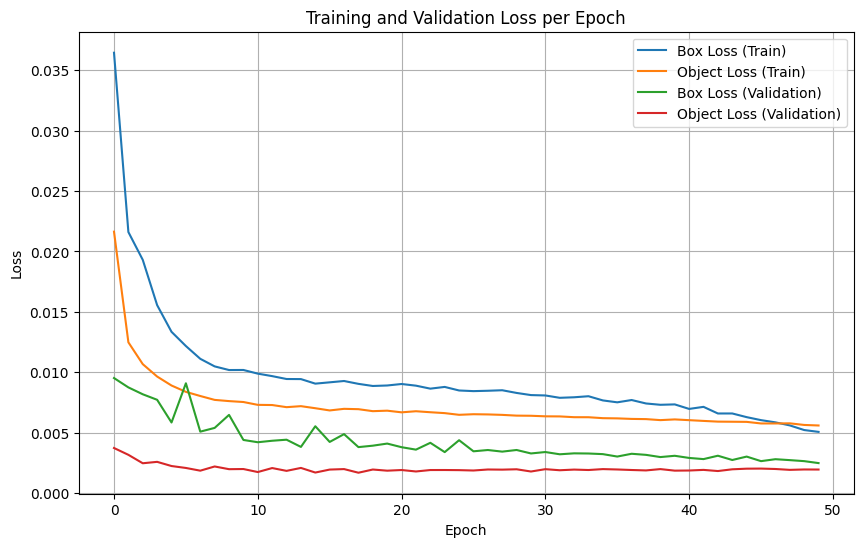

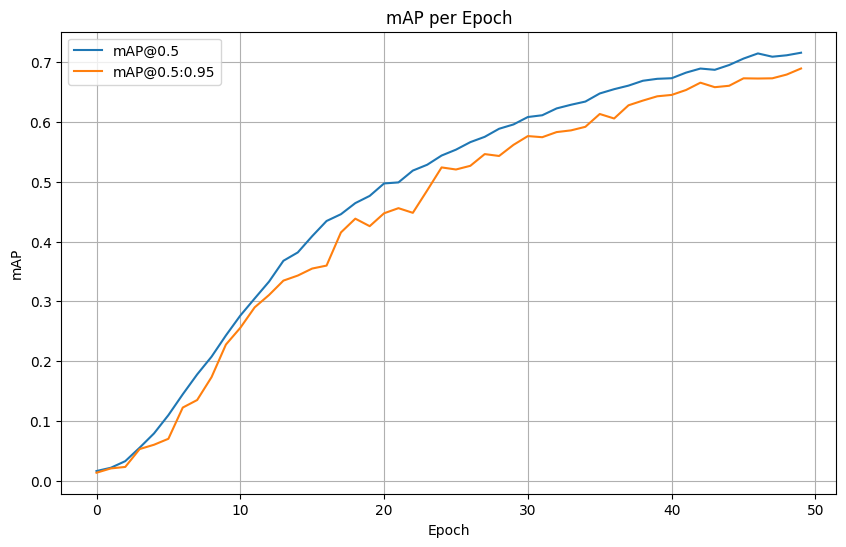

In [ ]:
# Plot training and validation losses
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['train/box_loss'], label='Box Loss (Train)')
plt.plot(results['epoch'], results['train/obj_loss'], label='Object Loss (Train)')
plt.plot(results['epoch'], results['val/box_loss'], label='Box Loss (Validation)')
plt.plot(results['epoch'], results['val/obj_loss'], label='Object Loss (Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid()
plt.show()


# Plot mAP (mean Average Precision)
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
plt.plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP per Epoch')
plt.legend()
plt.grid()
plt.show()


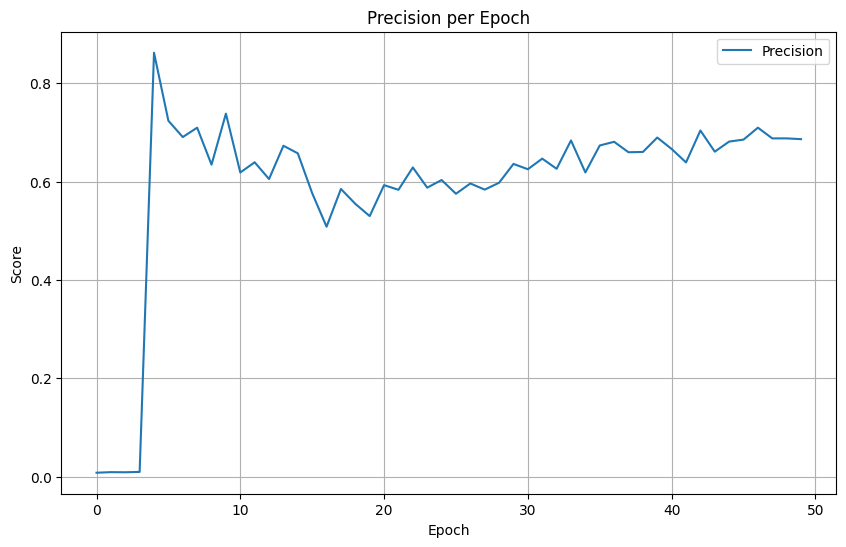

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/precision'], label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Precision per Epoch')
plt.legend()
plt.grid()
plt.show()


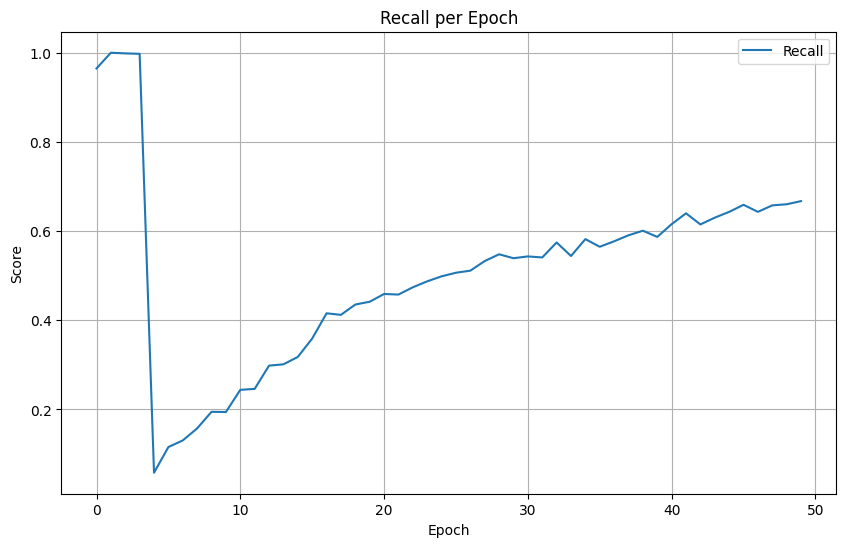

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(results['epoch'], results['metrics/recall'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Recall per Epoch')
plt.legend()
plt.grid()
plt.show()

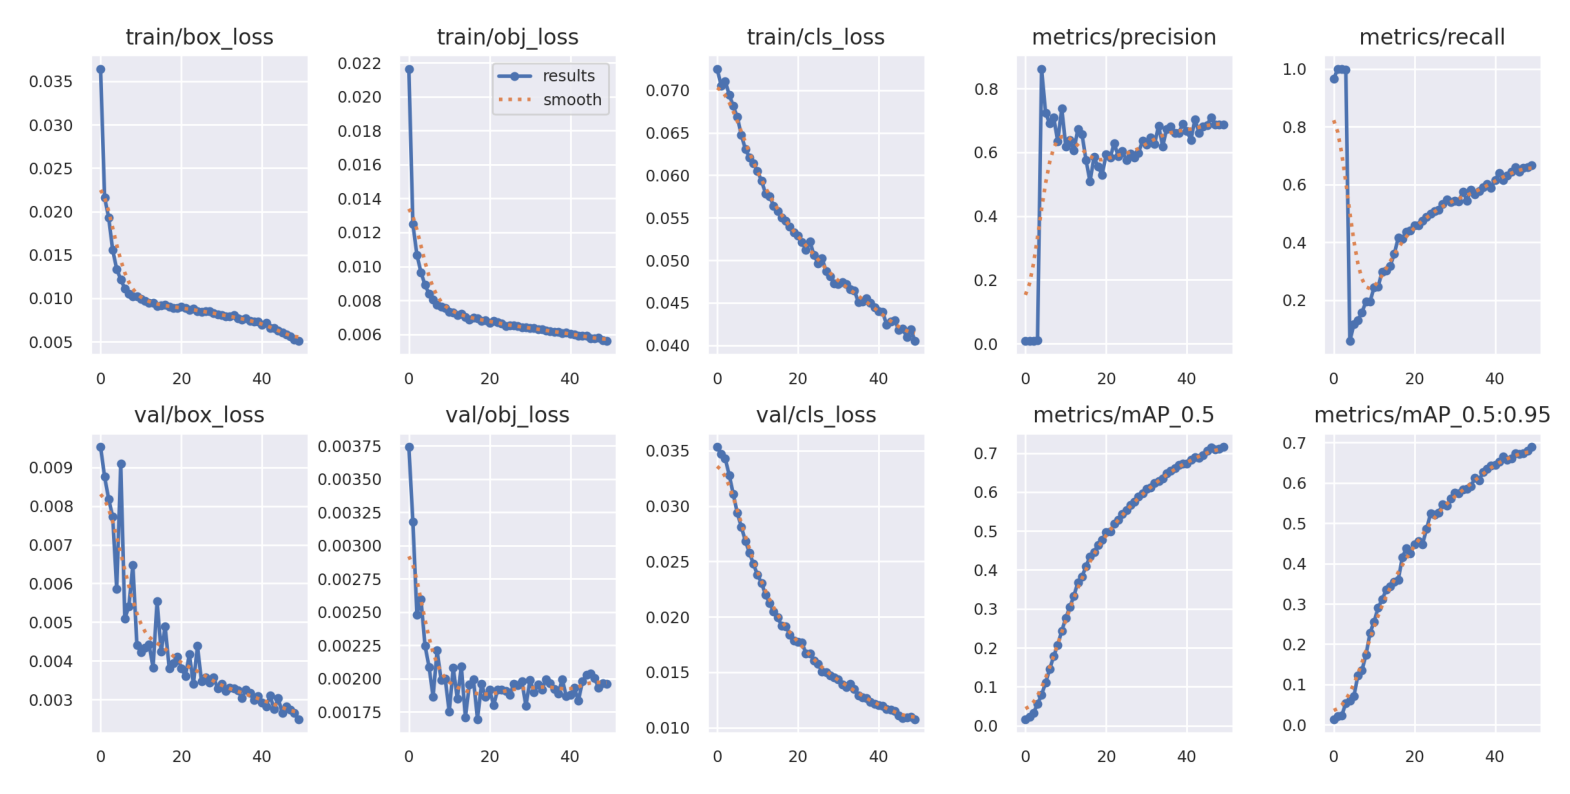

In [ ]:
img = plt.imread('/content/yolov5/runs/train/exp/results.png')
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.axis('off')
plt.show()

## Validation

In [ ]:
# Validate the model
!python val.py \
    --weights runs/train/exp/weights/best.pt \
    --data data.yaml \
    --img 640 \
    --task test


val: data=data.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7285219 parameters, 0 gradients, 16.6 GFLOPs
test: Scanning /content/yolov5/output_splits/split_2/test... 2048 images, 0 backgrounds, 0 corrupt: 100% 2048/2048 [00:04<00:00, 494.44it/s]
test: New cache created: /content/yolov5/output_splits/split_2/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 64/64 [00:33<00:00,  1.92it/s]
                   all       2048       2048      0.706      0.625      0.712      0.682
Speed: 0.3ms pre-process, 5.7ms infer

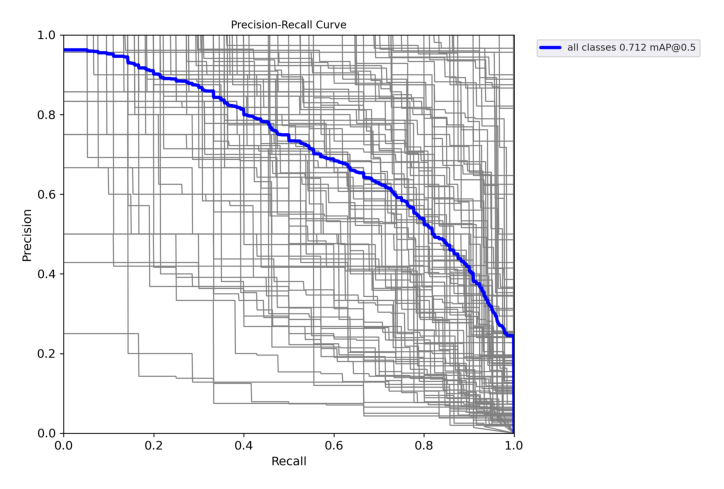

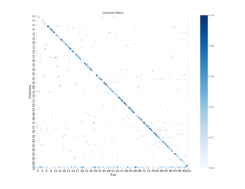

In [ ]:
c_matrix = plt.imread('/content/yolov5/runs/val/exp/confusion_matrix.png')
pr_curve = plt.imread('/content/yolov5/runs/val/exp/PR_curve.png')

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(pr_curve)
plt.axis('off')
plt.show()

plt.subplot(1,2,2)
plt.imshow(c_matrix)
plt.axis('off')
plt.show()